# Crash Predictive ML Model

We will create a tree based model to predict the daily number of crashes at a known intersection using the following:
- weather (temp, snow, rain, precip)
- day of week (Mon, Tues...)
- intersection characteristics
    - speed limit
    - volume of traffic
    - region
    - lanes/ways/turns/split/exit etc.
- violations (may want a violations independent model)
- red light cam present

In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from modules.myfuncs import *


import warnings
warnings.filterwarnings('ignore')


# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support


import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db



We will try to get data that is daily for all of the above info.  

In [3]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('signal_crashes',), ('all_hours',), ('int_startend',), ('intersection_chars',), ('hourly_congestion',)]
cam_locations
	camera_id
	intersection
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

cam_startend
	camera_id
	start
	end

daily_violations
	intersection
	camera_id
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

all_crashes
	crash_record_id
	rd_no
	crash_date
	posted_speed_limit
	traffic_control_device
	device_condition
	weather_condition
	lighting_condition
	first_crash_type
	trafficway_type
	alignment
	roadway_surface_cond
	road_defect
	report_type
	crash_type
	damage
	prim_contributory_cause
	sec_contributory_cause
	street_no
	street_direction
	street_name
	beat_of_occurrence
	num_units
	most_severe_injury
	injuries_total
	injuries_fatal
	injuries_incapacitating

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [4]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4) *153)


186009.75


## Query my db to get a DataFrame with crashes and intersection
We will be using the number of crashes and injuries to do some t-tests

In [7]:
# USE THIS ONE!!!!

# Takes 5 minutes

all_df = pd.read_sql_query('''WITH v AS(SELECT d.year,
                                                d.month,
                                                d.day,
                                                d.intersection,
                                                dv.violations,
                                                dv.violation_date,
                                                dv.weekday
                                               
                                        FROM all_hours as d

                                        LEFT JOIN daily_violations as dv
                                            ON d.year = dv.year
                                            AND d.month = dv.month
                                            AND d.day = dv.day
                                            AND d.intersection = dv.intersection
                                                
                                        ), 
                                        
                                    se AS(SELECT *
                                         FROM int_startend as se
                                        ),
                                        
                                    cr AS(SELECT *
                                         FROM signal_crashes
                                        ),
                                        
                                    ic AS(SELECT *
                                        FROM intersection_chars
                                        ),
                                        
                                    rg AS(SELECT *
                                        FROM intersection_cams),
                                        
                                    wx AS(SELECT MAX(temp) AS temp,
                                                (SUM(snow_1h) + SUM(rain_1h)) AS precip,
                                                SUM(snow_1h) AS snow_1h,
                                                SUM(rain_1h) AS rain_1h,
                                                year,
                                                month,
                                                day
                                        FROM hourly_weather
                                        GROUP BY year, month, day
                                        )
                                        
                                    SELECT  strftime('%W',v.violation_date) AS week,
                                            v.intersection,
                                            v.violation_date,
                                            v.violations,
                                            v.year,
                                            v.month,
                                            v.day,
                                        
                                            CAST(v.weekday AS TEXT) AS weekday,
                                    
                                            COUNT(DISTINCT cr.crash_record_id) as n_crash,

                                            cr.prim_contributory_cause,
                                            cr.sec_contributory_cause,
                                            SUM(cr.injuries_total) AS injuries,
                                            SUM(cr.injuries_fatal) AS injuries_fatal,
                                            SUM(cr.injuries_incapacitating) AS injuries_incapacitating,
                                                                                        
                                            ic.protected_turn,
                                            ic.total_lanes,
                                            ic.medians,
                                            ic.exit,
                                            ic.split,
                                            ic.way,
                                            ic.underpass,
                                            ic.no_left,
                                            ic.angled,
                                            ic.triangle,
                                            ic.one_way,
                                            ic.turn_lanes,
                                            ic.lat,
                                            ic.long,
                                            ic.rlc,
                                            ic.daily_traffic,
                                            ic.speed,

                                            se.start,
                                            se.end,
                                            
                                            rg.region_id,
                                            
                                            wx.temp,
                                            wx.precip,
                                            wx.snow_1h,
                                            wx.rain_1h
                                            
                                            
                                    FROM v
                                    LEFT JOIN wx
                                        ON wx.year = v.year
                                        AND wx.month = v.month
                                        AND wx.day = v.day
                                    LEFT JOIN se
                                        ON se.intersection = v.intersection
                                    LEFT JOIN ic
                                        ON ic.intersection = v.intersection
                                    LEFT JOIN rg
                                        ON rg.intersection = v.intersection
                                    LEFT JOIN cr
                                        ON cr.intersection = v.intersection
                                        AND cr.year = v.year
                                        AND cr.month = v.month
                                        AND cr.day = v.day
                                       
                                    WHERE v.violation_date >= \'2017-09-01\'

                                    
                                    GROUP BY v.year, week, v.intersection
                                    ORDER BY v.year, week, v.intersection;
                                    ''', conn)



In [8]:
print(all_df.info())
all_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26985 entries, 0 to 26984
Data columns (total 38 columns):
week                       26985 non-null object
intersection               26985 non-null object
violation_date             26985 non-null object
violations                 26985 non-null int64
year                       26985 non-null int64
month                      26985 non-null int64
day                        26985 non-null int64
weekday                    26985 non-null object
n_crash                    26985 non-null int64
prim_contributory_cause    861 non-null object
sec_contributory_cause     861 non-null object
injuries                   5048 non-null float64
injuries_fatal             5048 non-null float64
injuries_incapacitating    5048 non-null float64
protected_turn             26985 non-null int64
total_lanes                26985 non-null int64
medians                    26985 non-null int64
exit                       26985 non-null int64
split                 

,week,intersection,violation_date,violations,year,month,day,weekday,n_crash,prim_contributory_cause,...,rlc,daily_traffic,speed,start,end,region_id,temp,precip,snow_1h,rain_1h
0,35,111TH AND HALSTED,2017-09-01 00:00:00,8,2017,9,1,4,0,None,...,1,43100,35,2016-01-02 00:00:00,2021-02-02 00:00:00,26,294.15,0.0,0.0,0.0
1,35,115TH AND HALSTED,2017-09-01 00:00:00,11,2017,9,1,4,0,None,...,1,42500,35,2016-01-02 00:00:00,2017-10-26 00:00:00,26,294.15,0.0,0.0,0.0
2,35,119TH AND HALSTED,2017-09-01 00:00:00,7,2017,9,1,4,0,None,...,1,41800,35,2016-01-02 00:00:00,2021-02-02 00:00:00,26,294.15,0.0,0.0,0.0
3,35,31ST ST AND MARTIN LUTHER KING DRIVE,2017-09-01 00:00:00,10,2017,9,1,4,1,FAILING TO REDUCE SPEED TO AVOID CRASH,...,1,36500,35,2016-01-02 00:00:00,2021-02-02 00:00:00,16,294.15,0.0,0.0,0.0
4,35,35TH AND WESTERN,2017-09-01 00:00:00,5,2017,9,1,4,0,None,...,1,42400,35,2016-01-02 00:00:00,2021-02-02 00:00:00,15,294.15,0.0,0.0,0.0


In [9]:
# treat data as bool (did we have a wreck that day?)
y = all_df['n_crash'].fillna(0).astype(bool)

drop_cols = ['violation_date', 'day', 'prim_contributory_cause', 'sec_contributory_cause', 'injuries', 'injuries_fatal', 
             'injuries_incapacitating', 'start', 'end', 'n_crash', 'lat', 'long', 'rlc', 'n_crash']
categoricals = ['region_id', 'weekday']

X = all_df.drop(columns=drop_cols) 


In [10]:
all_df['n_crash'].value_counts()
#165550 / 5245
#5245 / 137
#137/10

X = pd.get_dummies(X)
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26985 entries, 0 to 26984
Columns: 260 entries, violations to region_id_9
dtypes: float64(4), int64(17), uint8(239)
memory usage: 10.5 MB


### Feature elimination
Doing this for the Logistic Regression model

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, solver='liblinear')


rfe = RFE(logreg)
rfe = rfe.fit(X, y)  # convert to int before using in logistic so I can do binary

In [12]:
auto_drop = []
keepers = []

for i in range(len(X.columns)):
    if rfe.support_[i]:
        print('Use: ', rfe.ranking_[i], X.columns[i])
        keepers.append(X.columns[i])
    else:
        print('Elim:', rfe.ranking_[i], X.columns[i])
        auto_drop.append(X.columns[i])

Elim: 72 violations
Elim: 64 year
Elim: 62 month
Elim: 67 protected_turn
Elim: 19 total_lanes
Elim: 57 medians
Use:  1 exit
Use:  1 split
Use:  1 way
Elim: 23 underpass
Elim: 51 no_left
Elim: 79 angled
Elim: 70 triangle
Elim: 10 one_way
Use:  1 turn_lanes
Elim: 73 daily_traffic
Elim: 28 speed
Elim: 55 temp
Elim: 48 precip
Elim: 33 snow_1h
Elim: 47 rain_1h
Use:  1 week_00
Use:  1 week_01
Use:  1 week_02
Use:  1 week_03
Use:  1 week_04
Use:  1 week_05
Elim: 103 week_06
Elim: 16 week_07
Elim: 108 week_08
Elim: 112 week_09
Elim: 126 week_10
Use:  1 week_11
Elim: 118 week_12
Use:  1 week_13
Use:  1 week_14
Use:  1 week_15
Use:  1 week_16
Elim: 97 week_17
Elim: 114 week_18
Elim: 77 week_19
Elim: 105 week_20
Elim: 86 week_21
Elim: 121 week_22
Use:  1 week_23
Use:  1 week_24
Elim: 120 week_25
Elim: 75 week_26
Use:  1 week_27
Elim: 117 week_28
Elim: 6 week_29
Use:  1 week_30
Use:  1 week_31
Elim: 129 week_32
Elim: 119 week_33
Elim: 4 week_34
Use:  1 week_35
Use:  1 week_36
Elim: 14 week_37
Use:

In [13]:
# accept the RFE results automatically
X = X.drop(columns=auto_drop) 

### Train test split

In [14]:
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Make ROC and find AUC

AUC: 0.6429339724434652


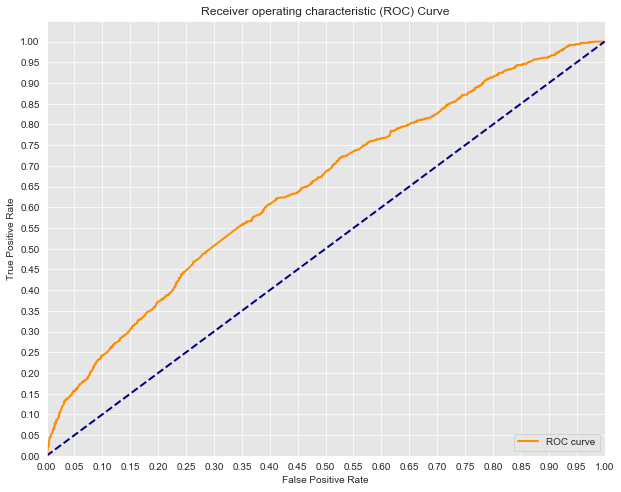

In [15]:
# Try logistic regression
# baseline model
X2 = X.copy()
y2 = y.copy()

y2 = y2.apply(lambda x: 1 if x > 0 else 0)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=42)

# Initial Model
logreg1 = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg1.fit(X2_train, y2_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y2_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.549500308772533
-------------------------------------------------------
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.01: 0.6156565770811608
-------------------------------------------------------
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
          

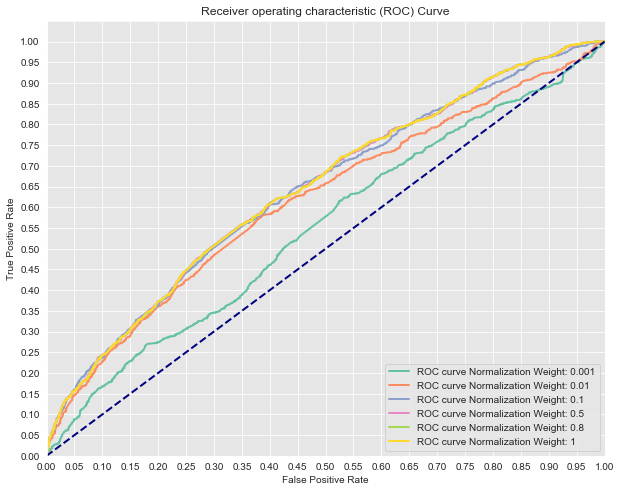

In [16]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 0.5, 0.8, 1]
names = [0.001, 0.01, 0.1, 0.5, 0.8 ,1]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X2_train, y2_train)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X2_test)

    y_score = logreg.fit(X2_train, y2_train).decision_function(X2_test)

    fpr, tpr, thresholds = roc_curve(y2_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Use the best one

AUC: 0.6429339724434652


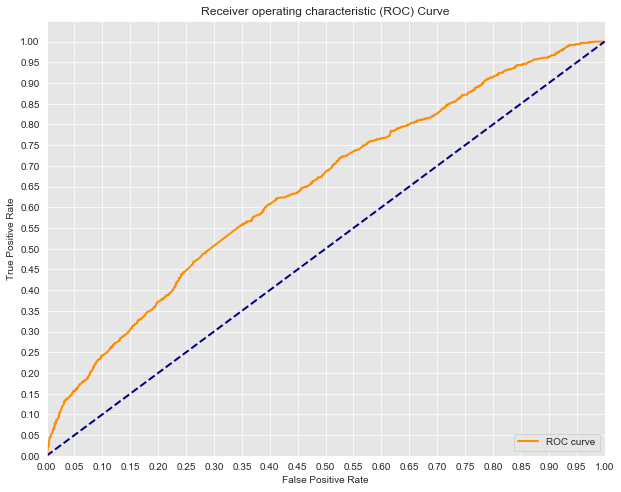

In [17]:
# Probability scores for test set
logreg1 = LogisticRegression(fit_intercept=False, C=1, solver='liblinear')

y_score = logreg1.fit(X2_train, y2_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y2_test, y_score)



# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Confusion Matrix 



0.26
Logreg score: 0.817


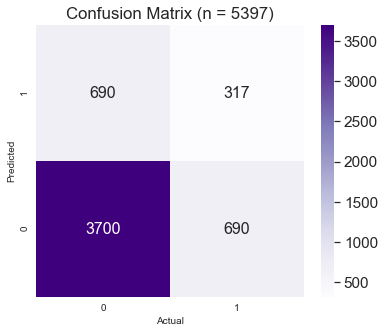

Actual True (crash): 1007, Predicted True: 1007
Actual False (no crash): 4390, Predicted False 4390
Percent days with crash: 18.66%

Precision: 0.786
Recall: 0.817
Fscore: 0.747


In [18]:
cutoff = 0.26
print(cutoff)
y_testbool = (logreg1.predict_proba(X2_test)[:,1] >= cutoff).astype(int)
#y_testbool = logreg1.predict(X_test)

score = logreg1.score(X2_test, y2_test)
print('Logreg score: {:.3f}'.format(score))

cm = confusion_matrix(y_testbool, y2_test.astype(bool).astype(int))
#y2_test.unique()
cm

fig, ax = plt.subplots(figsize = (6,5))
sns.set_context('poster')
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm.T, cmap="Purples", annot=True, fmt='g', annot_kws={"size": 16})# font size

plt.title("Confusion Matrix (n = {})".format(len(y2_test)))
plt.xlabel('Actual')
plt.ylabel('Predicted')
# Hide major tick labels


# Customize minor tick labels
ax.set_ylim([0,2])
ax.set_xlim([0,2])


#plt.annotate("No Crash: 0\n   Crash: 1", [1.1,0.1], fontsize=10)

plt.show()
# worked with other environment


# scoring model 
prec, recall, fscore, support = precision_recall_fscore_support(y_test, logreg1.predict(X_test), average='weighted')

n = len(y_test)
crash = y_test.sum()
pred_crash = y_testbool.sum()

print('Actual True (crash): {}, Predicted True: {}\nActual False (no crash): {}, Predicted False {}\nPercent days with crash: {:.2%}'.format(crash, pred_crash, n-crash, n-pred_crash, crash/n))
print('''\nPrecision: {:.3f}
Recall: {:.3f}
Fscore: {:.3f}'''.format(prec, recall, fscore))

## Machine Learning Improvement

In [19]:
# Machine learning improvement
n = cm[0].sum() + cm[1].sum()  # all test 

p0 = y_test.sum() / len(y_test)  # what is the guess rate I would use if I didn't know anything else
p1 = 1 - p0

guessing = p0**2 + p1**2

print('Probability with guessing: {:.3f}'.format(guessing))

ml = (cm[1][1] + cm[0][0]) / n
print('Probability with machine learning: {:.3f}'.format(ml))

increase = (ml - guessing) / guessing
print('\nPercent increase: {:.2%}'.format(increase))

Probability with guessing: 0.696
Probability with machine learning: 0.744

Percent increase: 6.87%


## Improve model with SMOTE Oversampling

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.5990109099628342
-------------------------------------------------------
LogisticRegression(C=0.002, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.002: 0.6052182558084298
-------------------------------------------------------
LogisticRegression(C=0.003, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
     

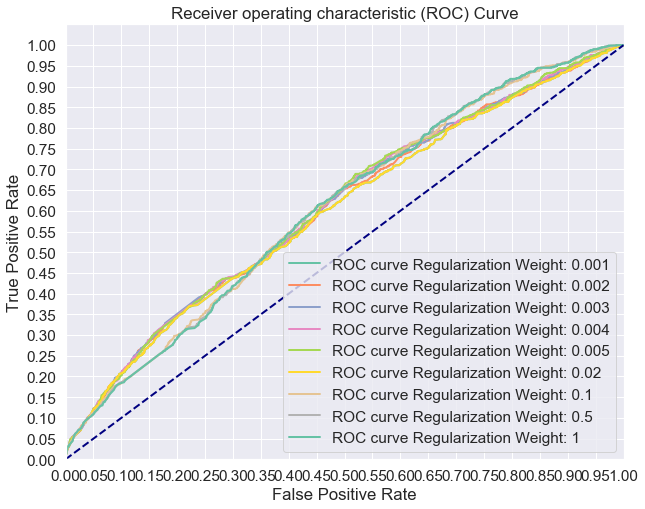

In [20]:
# SMOTE OVERSAMPLING
# Fit SMOTE to same training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X2_train, y2_train) 


# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.001, 0.002, 0.003, 0.004, 0.005, 0.001, 0.1, 0.5, 1]
names = [0.001, 0.002, 0.003, 0.004, 0.005, 0.02, 0.1, 0.5, 1]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X2_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X2_test)

    fpr, tpr, thresholds = roc_curve(y2_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Use the best c value for SMOTE

LogisticRegression(C=0.004, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 1: 0.608939360693822
-------------------------------------------------------


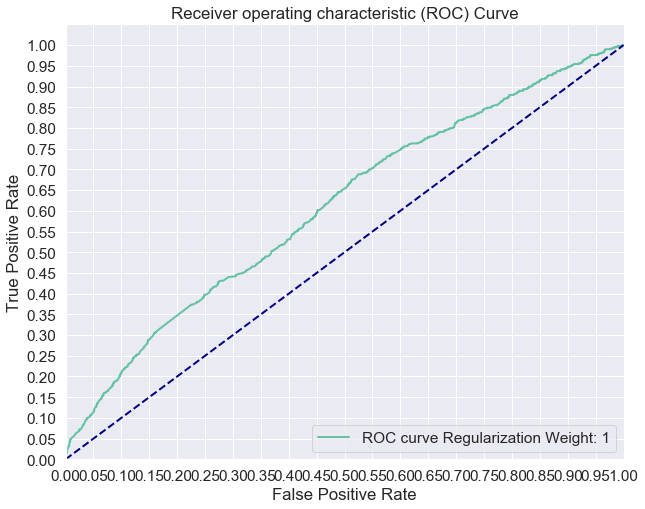

In [21]:
 # Fit a model
logreg_smote = LogisticRegression(fit_intercept=False, C=0.004, solver='liblinear')
model_log = logreg_smote.fit(X_train_resampled, y_train_resampled)
print(model_log) # Preview model params

# Predict
y_hat_test = logreg_smote.predict(X2_test)

y_score = logreg_smote.fit(X_train_resampled, y_train_resampled).decision_function(X2_test)

fpr, tpr, thresholds = roc_curve(y2_test, y_score)

print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
print('-------------------------------------------------------')

plt.figure(figsize=(10, 8))

lw = 2
plt.plot(fpr, tpr, color=colors[n],
         lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Confusion Matrix
Using boolean predictions did poorly.


0.6


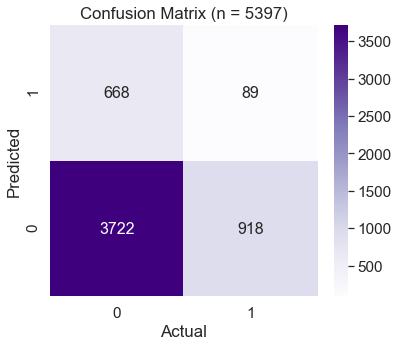

Actual True (crash): 1007, Predicted True: 757
Actual False (no crash): 4390, Predicted False 4640
Percent days with crash: 18.66%

Precision: 0.620
Recall: 0.620
Fscore: 0.620


In [22]:
cutoff = 0.6
print(cutoff)
# y_testbool = logreg_smote.predict(X2_test)  # -12% improvement
y_testbool = (logreg_smote.predict_proba(X2_test)[:,0] >= cutoff).astype(int)


logreg_smote.score(X2_test, y2_test)

cm = confusion_matrix(y_testbool, y2_test.astype(bool).astype(int))
#y2_test.unique()
cm

fig, ax = plt.subplots(figsize = (6,5))
sns.set_context('poster')
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="Purples", annot=True, fmt='g', annot_kws={"size": 16})# font size

plt.title("Confusion Matrix (n = {})".format(len(y2_test)))
plt.xlabel('Actual')
plt.ylabel('Predicted')
# Hide major tick labels


# Customize minor tick labels
ax.set_ylim([0,2])
ax.set_xlim([0,2])


#plt.annotate("No Crash: 0\n   Crash: 1", [1.1,0.1], fontsize=10)

plt.show()
# worked with other environment


# accuracy 


# scoring model 
prec, recall, fscore, support = precision_recall_fscore_support(y_test, logreg_smote.predict(X_test), average='micro')

n = len(y_test)
crash = y_test.sum()
pred_crash = y_testbool.sum()

print('Actual True (crash): {}, Predicted True: {}\nActual False (no crash): {}, Predicted False {}\nPercent days with crash: {:.2%}'.format(crash, pred_crash, n-crash, n-pred_crash, crash/n))
print('''\nPrecision: {:.3f}
Recall: {:.3f}
Fscore: {:.3f}'''.format(prec, recall, fscore))

## Machine Learning Improvement with SMOTE

In [95]:
# Machine learning improvement
n = cm[0].sum() + cm[1].sum()  # all test 

p0 = y_test.sum() / len(y_test)  # what is the guess rate I would use if I didn't know anything else
p1 = 1 - p0

guessing = p0**2 + p1**2

print('Probability with guessing: {:.3f}'.format(guessing))

ml = (cm[1][1] + cm[0][0]) / n
print('Probability with machine learning: {:.3f}'.format(ml))

increase = (ml - guessing) / guessing
print('\nPercent increase: {:.2%}'.format(increase))

Probability with guessing: 0.696
Probability with machine learning: 0.706

Percent increase: 1.39%


In [455]:
y_test

3589      True
905       True
9577     False
21805    False
16025    False
         ...  
15303    False
16215    False
11176    False
3165     False
16983    False
Name: n_crash, Length: 5397, dtype: bool

## Results
With Logisitic Regression, we were able to:
- improve our predictive power by 10 to 17.3% over weighted guessing, depending on how we adjust the cutoff value for the probability.
- identify the most important variables in our model (exit, split, ways, Thursday and Saturday, week of year, intersection, and region)

We were unable to improve the results using SMOTE.  Both ROC/AUC and score were worse, but wanted the code available if we decide to try the hourly data.